In [3]:
import os
import pickle

train_dataset_folder = '/home/jxl220096/data/hay/new_format/trial2/losangeles/train_stops/' 
n_agents = '50k'
with open(os.path.join(train_dataset_folder, f"preprocess/bw-0.1-K-10-25-rawX-0-agg-0-STKDE-0-comb-0-aggX-1/{n_agents}_train_agent_2_date_2_stopp_coords_dict.pkl"), 'rb') as f:
    agent_date_coords_dict_train = pickle.load(f)


In [14]:
print(len(list(agent_date_coords_dict_train.keys())))
print(list(agent_date_coords_dict_train.keys())[0])
print(list(agent_date_coords_dict_train[227873].keys()))
print(agent_date_coords_dict_train[227873][list(agent_date_coords_dict_train[227873].keys())[0]]) 
print(agent_date_coords_dict_train[227873][list(agent_date_coords_dict_train[227873].keys())[1]]) 
print(agent_date_coords_dict_train[227873][list(agent_date_coords_dict_train[227873].keys())[2]]) 


5000
227873
[datetime.date(2024, 1, 1), datetime.date(2024, 1, 2), datetime.date(2024, 1, 3), datetime.date(2024, 1, 4), datetime.date(2024, 1, 5), datetime.date(2024, 1, 7), datetime.date(2024, 1, 8), datetime.date(2024, 1, 9), datetime.date(2024, 1, 10), datetime.date(2024, 1, 11), datetime.date(2024, 1, 12), datetime.date(2024, 1, 13), datetime.date(2024, 1, 14), datetime.date(2024, 1, 15), datetime.date(2024, 1, 16), datetime.date(2024, 1, 17), datetime.date(2024, 1, 18), datetime.date(2024, 1, 19), datetime.date(2024, 1, 21), datetime.date(2024, 1, 22), datetime.date(2024, 1, 23), datetime.date(2024, 1, 24), datetime.date(2024, 1, 25), datetime.date(2024, 1, 26), datetime.date(2024, 1, 27), datetime.date(2024, 1, 28)]
[[  33.778469  -118.102379 ]
 [  33.8344499 -118.1875402]
 [  33.7784661 -118.1023803]
 [  33.8344498 -118.1875402]
 [  33.7978778 -118.1226502]]
[[  33.778468  -118.10238  ]
 [  33.8344499 -118.1875402]
 [  33.7784677 -118.1023807]
 [  33.8344498 -118.1875402]
 [  3

In [26]:
def read_traveldis(df, have_tel = True):
    """
    INPUT:
    df:         event list of a specific agent in the format of pandas data frame.
                columns: index, agent_id, timestamp, EventType, LocationType, LocationUUID, datetime, geometry, latitude, longitude
    have_tel:   True/False. True means that the trips have teleporting trips

    OUTPUT:
    The following are all related to one specific agent

    trip_features:      list (trip level) [start hour of day (float),end hour of day (float), travel_time in hours (float),
                                            travel_distance,start_lat,start_lon,end_lat,end_lon,day_week,
                                            start_dur (hours (float)),end_dur (hours (float))]
    trip_points:        list (trip level) [end_lat, end_lon]
    trip_datetime:      pandas data frame (trip level) [start_datetime, end_datetime, start_arr_datetime, end_dep_datetime]
                        start_datetime: the depature time of the start SP of each trip
                        end_datetime: the arrival time of the end SP of each trip
                        start_arr_datetime: the arrival time of the start SP
                        end_dep_datetime: the depature time of the end SP
    trip_locations:     list (trip level) [list of locations (LocationUUID) for each trip]
    trip_df_idx:        List (trip level) [start and end event indices of each trip]


    event_loc_type_dict: Dictionary (event level) {LocationUUID: LocationType}
    event_loc_adj_list:  List (event level) [LocationUUIDs of two adjacent events]
    roadseg_stopp_duration_returnlist: List (event level) [id of each event, duration between this event and its subsequent event]
    file_stopp2stopp_list (teleporting):       List of teleporting trips [start SP1 (LocationUUID) of a trip, end SP2 (LocationUUID) of the trip, travel time between the two SPs (arrival time of SP 2 - depature time of SP 1)]
                                        We require that the start and end SPs of each trip should not have  the same LocationUUID
    """
    df['arrival_day'] = df['arrival_datetime'].apply(lambda x: x.weekday())
    df['depart_day'] = df['depart_datetime'].apply(lambda x: x.weekday())
    df['Longitude'] = df['geometry'].apply(lambda x: float(x.replace('POINT (', '').replace(')','').split(' ')[0]))
    df['Latitude'] = df['geometry'].apply(lambda x: float(x.replace('POINT (', '').replace(')', '').split(' ')[1]))
    df = df.sort_values(by = ['time_start'], ascending = [True]).reset_index()
    trip_features = []
    trip_points = []
    count = 0
    trip_datetime_df = pd.DataFrame(columns=['start_datetime','end_datetime','start_arr_datetime','end_dep_datetime'])
    trip_locations = []
    trip_df_idx = []
    for i in range(df.shape[0]-1):
        start_index = i
        start_row = df.iloc[start_index]
        end_index = i + 1
        end_row = df.iloc[end_index]
        count = count + 1
        start_hour_of_day = float(start_row['depart_datetime'].hour) + float(start_row['depart_datetime'].minute) / 60
        end_hour_of_day = float(end_row['arrival_datetime'].hour) + float(end_row['arrival_datetime'].minute) / 60
        travel_time = diff_hour(start_row['depart_timestamp'], end_row['arrival_timestamp'])
        start_lat = start_row['Latitude']
        start_lon = start_row['Longitude']
        end_lat = end_row['Latitude']
        end_lon = end_row['Longitude']
        points=[[start_lat,start_lon], [end_lat,end_lon]]
        temp_list = [start_row['global_stop_points'], end_row['global_stop_points']]
        travel_distance = math.sqrt((start_lon - end_lon) ** 2 + (start_lat - end_lat) ** 2)
        trip_locations.append(temp_list)
        trip_points.append(points)

        day_week = float(start_row['depart_day'])
        start_dur = diff_hour(start_row['arrival_timestamp'], start_row['depart_timestamp'])
        end_dur = diff_hour(end_row['arrival_timestamp'], end_row['depart_timestamp'])
        trip_features.append([start_hour_of_day,end_hour_of_day,travel_time,travel_distance,start_lat,start_lon,end_lat,end_lon,day_week,start_dur,end_dur])

        # trip_datetime: pandas data frame [start_datetime, end_datetime, start_arr_datetime, end_dep_datetime]
        # start_datetime: the depature time of the start SP of a trip
        # end_datetime: the arrival time of the end SP of the trip
        # start_arr_datetime: the arrival time of the start SP
        # end_dep_datetime: the depature time of the end SP
        trip_datetime_df.loc[len(trip_datetime_df.index)] = [start_row['depart_datetime'],end_row['arrival_datetime'],start_row['arrival_datetime'],end_row['depart_datetime']]

        # trip_df_idx: [start and end event indices of each trip]
        trip_df_idx.append([start_index, end_index])
    return trip_features, trip_points, count, df.iloc[0]['agent_id'], trip_datetime_df, trip_locations, trip_df_idx

In [33]:
from datetime import datetime
import pandas as pd
import math

def to_datetime(timestamp):
    """Ensure the timestamp is converted to datetime object."""
    if not isinstance(timestamp, datetime):
        # Assuming the timestamp format is standard; adjust the format as needed.
        return pd.to_datetime(timestamp)
    return timestamp

def diff_hour(start_time, end_time):
    """
    Calculate the difference in hours between two datetime objects.

    Parameters:
    start_time (datetime or convertible): The start time.
    end_time (datetime or convertible): The end time.

    Returns:
    float: The difference in hours between start_time and end_time.
    """
    # Ensure both times are datetime objects
    start_time = to_datetime(start_time)
    end_time = to_datetime(end_time)

    # Calculate the time difference and convert it to hours
    time_diff = end_time - start_time
    hours_diff = time_diff.total_seconds() / 3600  # Convert seconds to hours
    return hours_diff


In [34]:
import pandas as pd

filename = '76442.parquet'
file_path = os.path.join(train_dataset_folder, filename)
df = pd.read_parquet(file_path)

if df['agent_id'].nunique() > 1:
    df                  = df.loc[df['agent_id'] == agent_id]
df = df.drop_duplicates(keep='first')
df = df.drop_duplicates(subset=["time_start"], keep='first')
df['arrival_datetime'] = pd.to_datetime(df['time_start'])
df['depart_datetime'] = pd.to_datetime(df['time_stop'])
df['arrival_timestamp'] = df['arrival_datetime'].apply(lambda x: x.timestamp())
df['depart_timestamp'] = df['depart_datetime'].apply(lambda x: x.timestamp())

trip_features, trip_points, trip_count, _, trip_datetime_df, trip_locations, trip_df_idx = read_traveldis(df, have_tel = True)

trip_datetime_df['weekday']       = trip_datetime_df['start_datetime'].apply(lambda x: x.weekday())
trip_datetime_df['dayofweek']     = trip_datetime_df['weekday'].apply(lambda x: 0 if x<4.5 else 1)
trip_datetime_df['start_time']    = trip_datetime_df['start_datetime'].apply(lambda x: x.time())
trip_datetime_df['end_time']      = trip_datetime_df['end_datetime'].apply(lambda x: x.time())
trip_datetime_df['start_date']    = trip_datetime_df['start_datetime'].apply(lambda x: x.date())
trip_datetime_df['end_weekday']   = trip_datetime_df['end_datetime'].apply(lambda x: x.weekday())
trip_datetime_df['end_dayofweek'] = trip_datetime_df['end_weekday'].apply(lambda x: 0 if x<4.5 else 1)
trip_start_end_datetimes_df       = trip_datetime_df[['start_datetime', 'end_datetime']]



In [43]:
import numpy as np

n_trips = len(trip_features) # list of trip-level feature vectors
raw_X = np.array(trip_features).astype(float)
X = np.zeros((n_trips, 9))
# print(trip_features)
# print("X[:, 0], raw_X[:, 2]", X, raw_X)
X[:, 0]  = raw_X[:, 2]  # travel_times of the trips (third column in raw_X)
X[:, 1]  = np.sqrt((raw_X[:, 4] - raw_X[:, 6]) ** 2 + (raw_X[:, 5] - raw_X[:, 7]) ** 2) # Euclidean disance between start and end stop points

date_2_stopp_coords_dict  = dict()
trip_datetime_coords_df = trip_datetime_df.copy()
trip_datetime_coords_df['start_lat'] =  raw_X[:, 4] # start latitude
trip_datetime_coords_df['start_lon'] =  raw_X[:, 5] # start longitude
trip_datetime_df['hour_of_day'] = pd.to_datetime(trip_datetime_df['start_time'], format='%H:%M:%S').dt.hour

trips_date_group = trip_datetime_coords_df.groupby(by='start_date')
for i_date, i_group in trips_date_group:
    temp_coords_list = i_group[['start_lat', 'start_lon', 'hour_of_day']].values
    date_2_stopp_coords_dict[i_date] = temp_coords_list  


In [47]:
agent_id = df['agent_id'].unique()[0]
print(agent_id)

76442


In [48]:


def agent_date_time_sp_corrds_dict(folder_path):
    agent_date_time_sp_corrds_dict = dict()

    for subdir in os.listdir(folder_path):
        subdir_path = os.path.join(folder_path, subdir)
        if os.path.isdir(subdir_path):
            for filename in os.listdir(subdir_path):
                if filename.endswith('.parquet'):
                    file_path = os.path.join(subdir_path, filename)
                    df = pd.read_parquet(file_path)
                    if df['agent_id'].nunique() > 1:
                        df = df.loc[df['agent_id'] == agent_id]
                    df = df.drop_duplicates(keep='first')
                    df = df.drop_duplicates(subset=["time_start"], keep='first')
                    df['arrival_datetime'] = pd.to_datetime(df['time_start'])
                    df['depart_datetime'] = pd.to_datetime(df['time_stop'])
                    df['arrival_timestamp'] = df['arrival_datetime'].apply(lambda x: x.timestamp())
                    df['depart_timestamp'] = df['depart_datetime'].apply(lambda x: x.timestamp())

                    trip_features, trip_points, trip_count, _, trip_datetime_df, trip_locations, trip_df_idx = read_traveldis(df, have_tel = True)

                    trip_datetime_df['weekday']       = trip_datetime_df['start_datetime'].apply(lambda x: x.weekday())
                    trip_datetime_df['dayofweek']     = trip_datetime_df['weekday'].apply(lambda x: 0 if x<4.5 else 1)
                    trip_datetime_df['start_time']    = trip_datetime_df['start_datetime'].apply(lambda x: x.time())
                    trip_datetime_df['end_time']      = trip_datetime_df['end_datetime'].apply(lambda x: x.time())
                    trip_datetime_df['start_date']    = trip_datetime_df['start_datetime'].apply(lambda x: x.date())
                    trip_datetime_df['end_weekday']   = trip_datetime_df['end_datetime'].apply(lambda x: x.weekday())
                    trip_datetime_df['end_dayofweek'] = trip_datetime_df['end_weekday'].apply(lambda x: 0 if x<4.5 else 1)
                    trip_start_end_datetimes_df       = trip_datetime_df[['start_datetime', 'end_datetime']]

                    n_trips = len(trip_features) # list of trip-level feature vectors
                    raw_X = np.array(trip_features).astype(float)
                    X = np.zeros((n_trips, 9))
                    # print(trip_features)
                    # print("X[:, 0], raw_X[:, 2]", X, raw_X)
                    X[:, 0]  = raw_X[:, 2]  # travel_times of the trips (third column in raw_X)
                    X[:, 1]  = np.sqrt((raw_X[:, 4] - raw_X[:, 6]) ** 2 + (raw_X[:, 5] - raw_X[:, 7]) ** 2) # Euclidean disance between start and end stop points

                    date_2_stopp_coords_dict  = dict()
                    trip_datetime_coords_df = trip_datetime_df.copy()
                    trip_datetime_coords_df['start_lat'] =  raw_X[:, 4] # start latitude
                    trip_datetime_coords_df['start_lon'] =  raw_X[:, 5] # start longitude
                    trip_datetime_df['hour_of_day'] = pd.to_datetime(trip_datetime_df['start_time'], format='%H:%M:%S').dt.hour

                    trips_date_group = trip_datetime_coords_df.groupby(by='start_date')
                    for i_date, i_group in trips_date_group:
                        temp_coords_list = i_group[['start_lat', 'start_lon', 'hour_of_day']].values
                        date_2_stopp_coords_dict[i_date] = temp_coords_list  

                    agent_id = df['agent_id'].unique()[0]

                    agent_date_time_sp_corrds_dict[agent_id] = date_2_stopp_coords_dict
    return agent_date_time_sp_corrds_dict

train_agent_date_time_sp_corrds_dict = agent_date_time_sp_corrds_dict(train_dataset_folder)
test_agent_date_time_sp_corrds_dict = agent_date_time_sp_corrds_dict(test_dataset_folder)

save_to_pickle(train_dataset_folder + "preprocess/" + "{}{}train_agent_date_time_sp_corrds_dict.pkl".format('preprocess/', subsample_label),  train_agent_date_time_sp_corrds_dict)
save_to_pickle(test_dataset_folder + "preprocess/" + "{}{}test_agent_date_time_sp_corrds_dict.pkl".format('preprocess/', subsample_label),  test_agent_date_time_sp_corrds_dict)


TypeError: agent_date_time_sp_corrds_dict() takes 0 positional arguments but 1 was given

In [ ]:
def read_traveldis(df, have_tel = True):
    """
    INPUT:
    df:         event list of a specific agent in the format of pandas data frame.
                columns: index, agent_id, timestamp, EventType, LocationType, LocationUUID, datetime, geometry, latitude, longitude
    have_tel:   True/False. True means that the trips have teleporting trips

    OUTPUT:
    The following are all related to one specific agent

    trip_features:      list (trip level) [start hour of day (float),end hour of day (float), travel_time in hours (float),
                                            travel_distance,start_lat,start_lon,end_lat,end_lon,day_week,
                                            start_dur (hours (float)),end_dur (hours (float))]
    trip_points:        list (trip level) [end_lat, end_lon]
    trip_datetime:      pandas data frame (trip level) [start_datetime, end_datetime, start_arr_datetime, end_dep_datetime]
                        start_datetime: the depature time of the start SP of each trip
                        end_datetime: the arrival time of the end SP of each trip
                        start_arr_datetime: the arrival time of the start SP
                        end_dep_datetime: the depature time of the end SP
    trip_locations:     list (trip level) [list of locations (LocationUUID) for each trip]
    trip_df_idx:        List (trip level) [start and end event indices of each trip]


    event_loc_type_dict: Dictionary (event level) {LocationUUID: LocationType}
    event_loc_adj_list:  List (event level) [LocationUUIDs of two adjacent events]
    roadseg_stopp_duration_returnlist: List (event level) [id of each event, duration between this event and its subsequent event]
    file_stopp2stopp_list (teleporting):       List of teleporting trips [start SP1 (LocationUUID) of a trip, end SP2 (LocationUUID) of the trip, travel time between the two SPs (arrival time of SP 2 - depature time of SP 1)]
                                        We require that the start and end SPs of each trip should not have  the same LocationUUID
    """
    df['arrival_day'] = df['arrival_datetime'].apply(lambda x: x.weekday())
    df['depart_day'] = df['depart_datetime'].apply(lambda x: x.weekday())
    df['Longitude'] = df['geometry'].apply(lambda x: float(x.replace('POINT (', '').replace(')','').split(' ')[0]))
    df['Latitude'] = df['geometry'].apply(lambda x: float(x.replace('POINT (', '').replace(')', '').split(' ')[1]))
    df = df.sort_values(by = ['time_start'], ascending = [True]).reset_index()
    trip_features = []
    trip_points = []
    count = 0
    trip_datetime_df = pd.DataFrame(columns=['start_datetime','end_datetime','start_arr_datetime','end_dep_datetime'])
    trip_locations = []
    trip_df_idx = []
    for i in range(df.shape[0]-1):
        start_index = i
        start_row = df.iloc[start_index]
        end_index = i + 1
        end_row = df.iloc[end_index]
        count = count + 1
        start_hour_of_day = float(start_row['depart_datetime'].hour) + float(start_row['depart_datetime'].minute) / 60
        end_hour_of_day = float(end_row['arrival_datetime'].hour) + float(end_row['arrival_datetime'].minute) / 60
        travel_time = diff_hour(start_row['depart_timestamp'], end_row['arrival_timestamp'])
        start_lat = start_row['Latitude']
        start_lon = start_row['Longitude']
        end_lat = end_row['Latitude']
        end_lon = end_row['Longitude']
        points=[[start_lat,start_lon], [end_lat,end_lon]]
        temp_list = [start_row['global_stop_points'], end_row['global_stop_points']]
        travel_distance = math.sqrt((start_lon - end_lon) ** 2 + (start_lat - end_lat) ** 2)
        trip_locations.append(temp_list)
        trip_points.append(points)

        day_week = float(start_row['depart_day'])
        start_dur = diff_hour(start_row['arrival_timestamp'], start_row['depart_timestamp'])
        end_dur = diff_hour(end_row['arrival_timestamp'], end_row['depart_timestamp'])
        trip_features.append([start_hour_of_day,end_hour_of_day,travel_time,travel_distance,start_lat,start_lon,end_lat,end_lon,day_week,start_dur,end_dur])

        # trip_datetime: pandas data frame [start_datetime, end_datetime, start_arr_datetime, end_dep_datetime]
        # start_datetime: the depature time of the start SP of a trip
        # end_datetime: the arrival time of the end SP of the trip
        # start_arr_datetime: the arrival time of the start SP
        # end_dep_datetime: the depature time of the end SP
        trip_datetime_df.loc[len(trip_datetime_df.index)] = [start_row['depart_datetime'],end_row['arrival_datetime'],start_row['arrival_datetime'],end_row['depart_datetime']]

        # trip_df_idx: [start and end event indices of each trip]
        trip_df_idx.append([start_index, end_index])

    return trip_features, trip_points, count, df.iloc[0]['agent_id'], trip_datetime_df, trip_locations, trip_df_idx

def diff_hour(start_time, end_time):
    """
    Calculate the difference in hours between two datetime objects.

    Parameters:
    start_time (datetime or convertible): The start time.
    end_time (datetime or convertible): The end time.

    Returns:
    float: The difference in hours between start_time and end_time.
    """
    # Ensure both times are datetime objects
    start_time = to_datetime(start_time)
    end_time = to_datetime(end_time)

    # Calculate the time difference and convert it to hours
    time_diff = end_time - start_time
    hours_diff = time_diff.total_seconds() / 3600  # Convert seconds to hours
    return hours_diff

def to_datetime(timestamp):
    """Ensure the timestamp is converted to datetime object."""
    if not isinstance(timestamp, datetime):
        # Assuming the timestamp format is standard; adjust the format as needed.
        return pd.to_datetime(timestamp)
    return timestamp

In [21]:
def process_dataframe(df):
    """Process the dataframe to extract trip dates, coordinates and other features."""
    df['arrival_datetime'] = pd.to_datetime(df['time_start'])
    # df['depart_datetime'] = pd.to_datetime(df['time_stop'])
    # Assuming the format is Year-Month-Day Hours:Minutes:Seconds
    df['depart_datetime'] = pd.to_datetime(df['time_stop'], format='%Y-%m-%d %H:%M:%S')

    df['arrival_timestamp'] = df['arrival_datetime'].apply(lambda x: x.timestamp())
    df['depart_timestamp'] = df['depart_datetime'].apply(lambda x: x.timestamp())
    
    # Assuming 'read_traveldis' processes df and returns trip details
    trip_features, _, _, _, trip_datetime_df, _, _ = read_traveldis(df, have_tel=True)
    
    # Extracting start and end times, days
    trip_datetime_df['start_date'] = trip_datetime_df['start_datetime'].dt.date
    trip_datetime_df['hour_of_day'] = trip_datetime_df['start_datetime'].dt.hour
    
    return trip_features, trip_datetime_df


def compile_agent_data(folder_path, agent_id, filename):

    # Read parquet files
    file_path = os.path.join(folder_path, filename)
    df = pd.read_parquet(file_path)

    if df.empty:
        print("No data found for the specified agent ID.")
        return {}

    # Process dataframe
    trip_features, trip_datetime_df = process_dataframe(df)
    # print('trip_features', trip_features) -- start_hour_of_day,end_hour_of_day,travel_time,travel_distance,start_lat,start_lon,end_lat,end_lon,day_week,start_dur,end_dur

    # Adding coordinates and time data to trip data
    trip_datetime_df['start_lat'] = trip_features['start_lat']
    trip_datetime_df['start_lon'] = trip_features['start_lon']
    trip_datetime_df['hour_of_day'] = trip_features['start_hour_of_day']
    
    date_to_coords_dict = trip_datetime_df.groupby('start_date').apply(
        lambda group: group[['start_lat', 'start_lon', 'hour_of_day']].values.tolist()
    ).to_dict()

    return date_to_coords_dict



In [3]:
import os
import numpy as np
import pandas as pd
import pickle

train_dataset_dir = '/home/jxl220096/data/hay/new_format/trial2/losangeles/train_stops/'

with open(os.path.join(train_dataset_dir, f"preprocess/train_500_agent_date_time_sp_coords_dict.pkl"), 'rb') as f:
    agent_date_coords_dict_train = pickle.load(f)
print('agent_date_coords_dict_train', agent_date_coords_dict_train.keys())
print('agent_date_coords_dict_train', agent_date_coords_dict_train[141664])


agent_date_coords_dict_train dict_keys([141664, 286027, 69239, 134276, 266631, 73482, 140438, 53973, 70739, 82338, 187492, 228550, 74027, 216848, 85256, 64116, 250428, 179548, 250251, 290172, 70827, 183780, 246024, 233941, 209952, 39922, 258120, 47025, 8835, 23664, 155074, 94511, 249100, 40675, 121234, 123378, 62016, 127567, 10531, 49201, 227510, 106533, 262383, 197509, 192153, 108074, 266021, 38795, 31012, 30906, 16743, 221824, 151875, 35845, 153292, 198635, 164749, 128070, 175237, 19725, 132533, 76956, 53165, 85614, 107633, 144540, 34654, 283307, 248120, 224687, 101104, 190416, 52653, 16384, 95678, 176480, 288017, 288209, 30755, 75292, 132829, 287431, 285900, 158762, 163075, 73153, 265218, 56793, 101830, 61824, 227733, 142555, 70320, 140445, 69647, 246613, 115011, 157801, 89609, 229918, 98240, 58808, 70875, 6193, 215821, 52589, 250012, 94005, 52750, 216682, 20345, 168145, 52010, 244843, 83208, 148066, 109189, 153211, 125152, 2540, 57705, 134765, 30461, 279975, 221200, 100747, 181245,

In [22]:
from datetime import datetime
import math
compile_agent_data(train_dataset_dir, 81552, '81552.parquet' )

trip_features [[19.483333333333334, 19.55, 0.0, 0.031116987615466083, 34.068389999999994, -118.00776700000002, 34.0657701, -117.9767605, 0.0, 1.138888888888889e-08, 1.6666666666666667e-09], [21.25, 21.35, 0.0, 0.031116698517836106, 34.0657701, -117.9767605, 34.068391299999995, -118.0077666, 0.0, 1.6666666666666667e-09, 5.555555555555555e-10], [21.966666666666665, 22.033333333333335, 0.0, 0.031116083803228372, 34.068391299999995, -118.0077666, 34.06577029999999, -117.9767611, 0.0, 5.555555555555555e-10, 8.333333333333334e-10], [22.95, 23.05, 0.0, 0.031117537796214307, 34.06577029999999, -117.9767611, 34.068392, -118.00776799999998, 0.0, 8.333333333333334e-10, 1.9722222222222225e-08], [19.033333333333335, 19.15, 0.0, 0.03506620315716601, 34.068392, -118.00776799999998, 34.1034551, -118.0073015, 1.0, 1.9722222222222225e-08, 2.222222222222222e-09], [21.483333333333334, 21.616666666666667, 0.0, 0.03506620315716601, 34.1034551, -118.0073015, 34.068392, -118.00776799999998, 1.0, 2.22222222222

{datetime.date(2024, 1, 1): [[0.0, 0.0, 19.0],
  [0.0, 0.0, 21.0],
  [0.0, 0.0, 21.0],
  [0.0, 0.0, 22.0]],
 datetime.date(2024, 1, 2): [[0.0, 0.0, 19.0], [0.0, 0.0, 21.0]],
 datetime.date(2024, 1, 3): [[0.0, 0.0, 18.0], [0.0, 0.0, 21.0]],
 datetime.date(2024, 1, 4): [[0.0, 0.0, 19.0], [0.0, 0.0, 21.0]],
 datetime.date(2024, 1, 5): [[0.0, 0.0, 19.0], [0.0, 0.0, 21.0]],
 datetime.date(2024, 1, 6): [[0.0, 0.0, 19.0], [0.0, 0.0, 23.0]],
 datetime.date(2024, 1, 7): [[0.0, 0.0, 18.0], [0.0, 0.0, 21.0]],
 datetime.date(2024, 1, 8): [[0.0, 0.0, 18.0], [0.0, 0.0, 19.0]],
 datetime.date(2024, 1, 9): [[0.0, 0.0, 18.0], [0.0, 0.0, 21.0]],
 datetime.date(2024, 1, 10): [[0.0, 0.0, 21.0], [0.0, 0.0, 22.0]],
 datetime.date(2024, 1, 11): [[0.0, 0.0, 21.0], [0.0, 0.0, 23.0]],
 datetime.date(2024, 1, 12): [[0.0, 0.0, 18.0], [0.0, 0.0, 19.0]],
 datetime.date(2024, 1, 13): [[0.0, 0.0, 20.0], [0.0, 0.0, 21.0]],
 datetime.date(2024, 1, 14): [[0.0, 0.0, 20.0],
  [0.0, 0.0, 22.0],
  [0.0, 0.0, 23.0],
  [0.0, 

/tmp/ipykernel_2447240/554028023.py:69: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


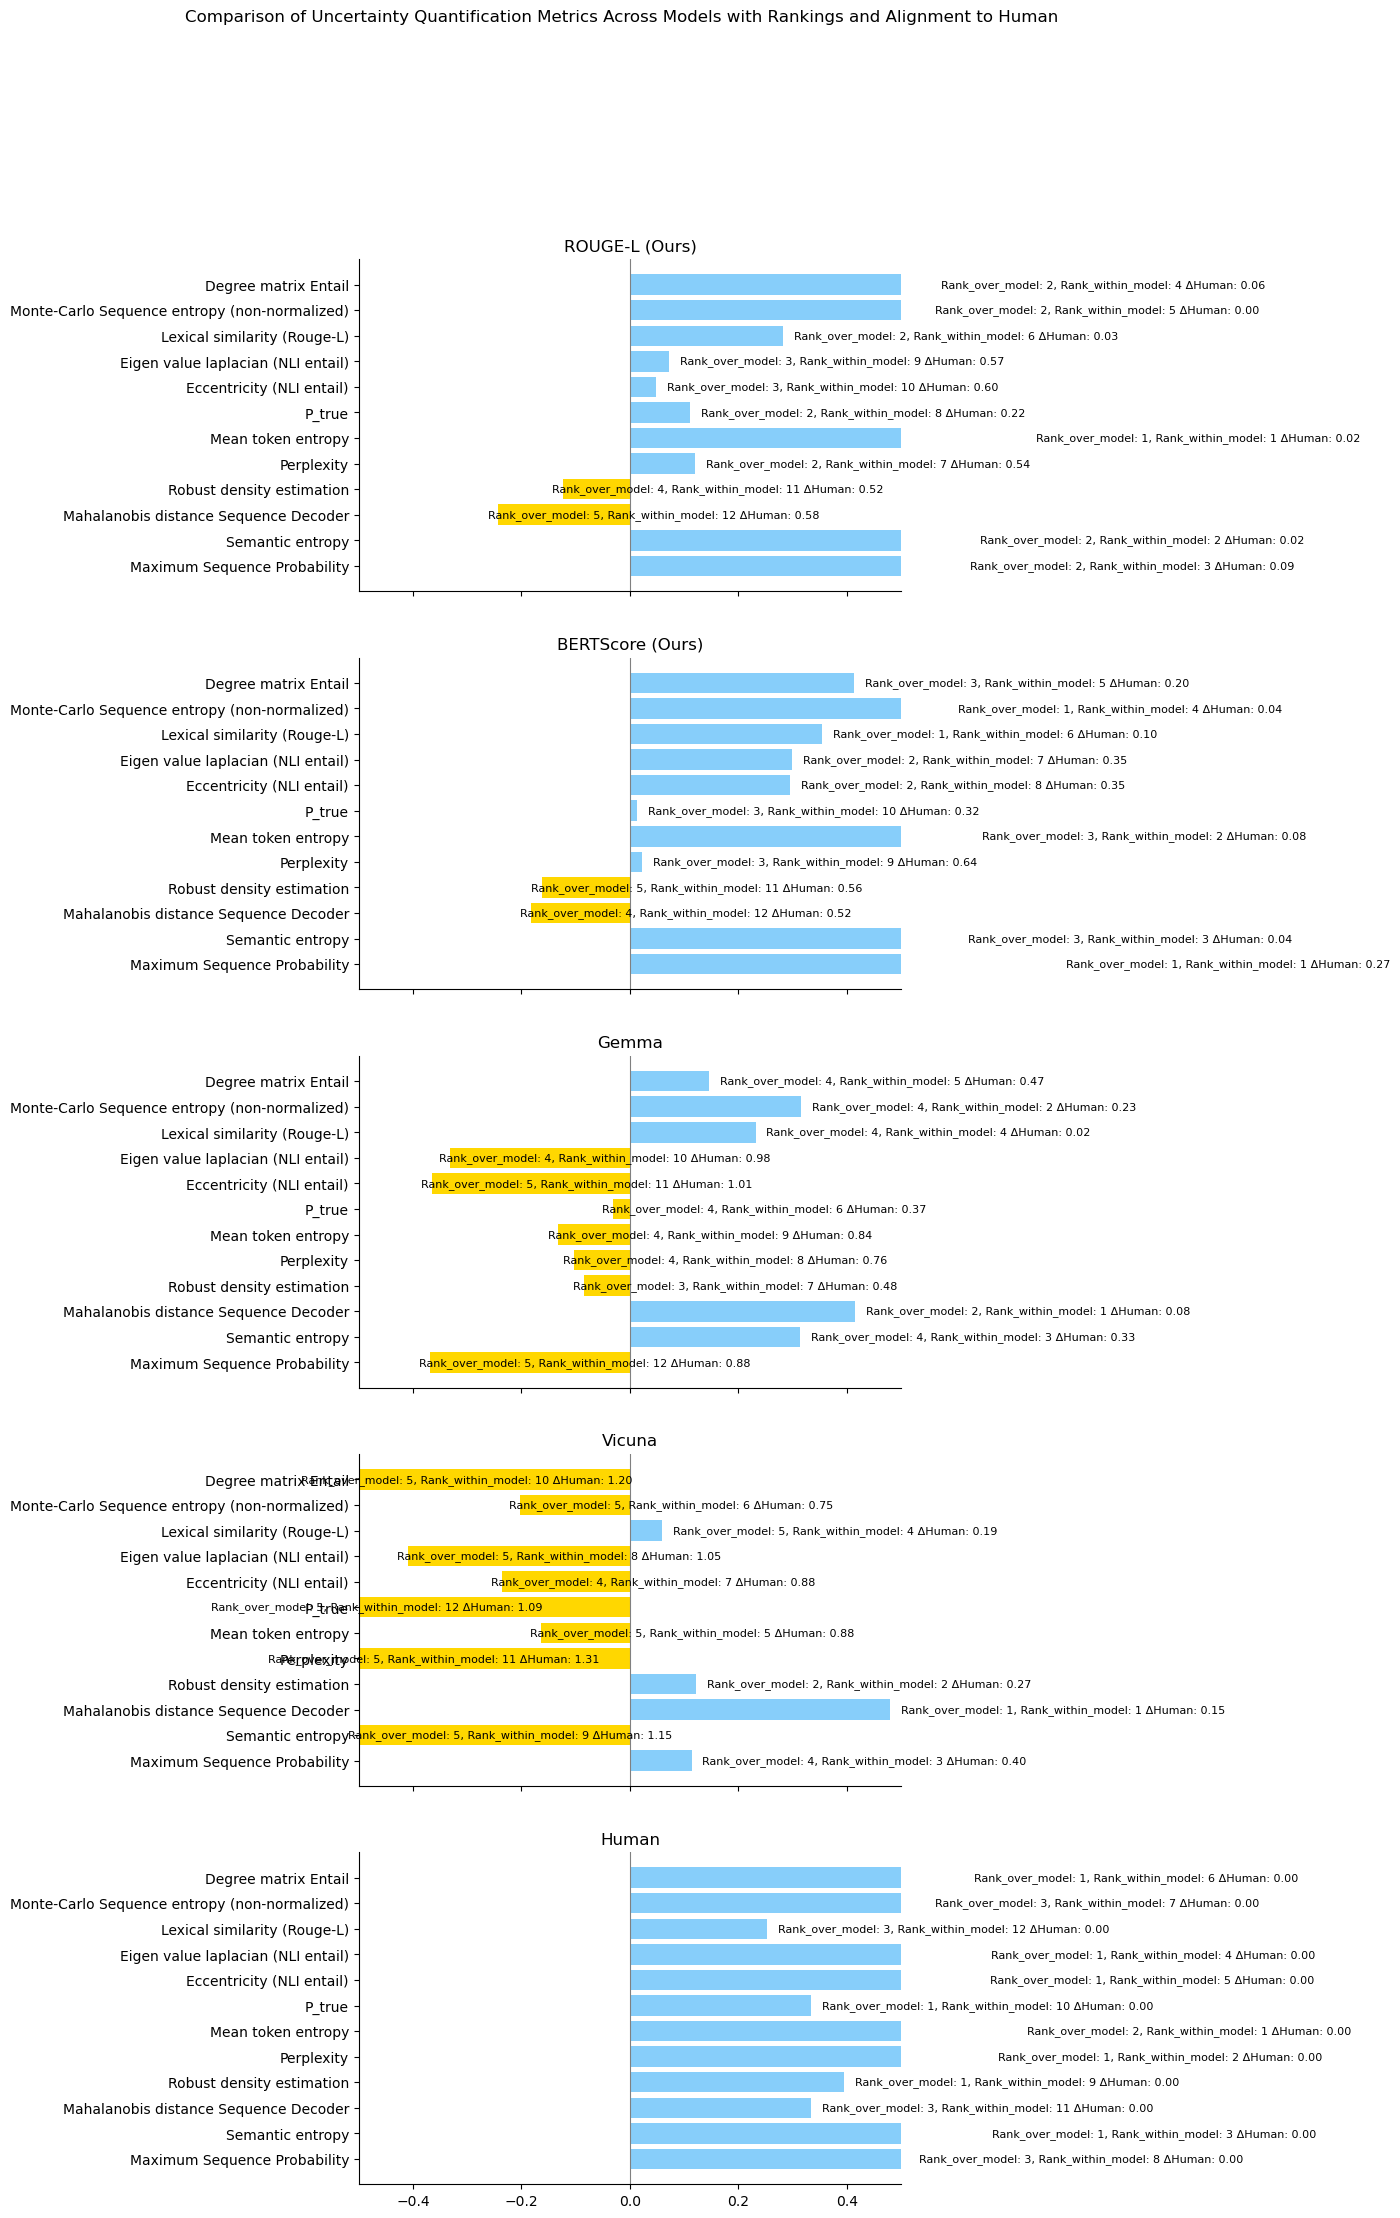

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Correcting the dimensions and labels for plotting
metrics = ['Maximum Sequence Probability', 'Semantic entropy', 'Mahalanobis distance Sequence Decoder',
           'Robust density estimation', 'Perplexity', 'Mean token entropy', 'P_true', 'Eccentricity (NLI entail)',
           'Eigen value laplacian (NLI entail)', 'Lexical similarity (Rouge-L)', 'Monte-Carlo Sequence entropy (non-normalized)',
           'Degree matrix Entail']

## ---------- COQA
model_scores = {
    'ROUGE-L (Ours)': [0.39892, 0.39973, -0.044122, 0.403298, 0.2551952, 0.287, -0.09814, 0.39961, 0.3939, 0.4016645, 0.3953674, 0.35564113],
    'BERTScore (Ours)': [0.4099, 0.398208, 0.04804, 0.4017, 0.095197, 0.10634, -0.2564, 0.393922, 0.41273, 0.42692, 0.4012902, 0.336562],
    'Gemma': [0.28033, 0.28574, -0.139, -0.04686, 0.3815, 0.41985, 0.13635, 0.26876, 0.2978, 0.2457, 0.2779, 0.2797],
    'Vicuna': [-0.0896, 0.12, -0.23783, -0.19295, 0.1662, 0.1915, 0.4328, -0.0503, -0.0809, -0.07921, -0.07804, -0.08715],
    'Human': [0.15596, 0.18038, -0.012558, -0.044015, 0.15951, 0.1686, -0.0267, 0.12231, 0.12989, 0.090597, 0.146547, 0.17308]
}

## ----------bAbiQA
model_scores = {
    'ROUGE-L (Ours)':  [0.0741, 0.530388, 0.437715, 0.3454887, 0.57518, 0.0648, 0.08, 0.14892, 0.19126, 0.44319565, 0.587944133, 0.47576424],
    'BERTScore (Ours)': [ 0.8843, 0.860979, 0.121345, 0.2011368, 0.95098, 0.9009, 0.05805, 0.6195, 0.6236, 0.8722321, 0.962174, 0.8820208],
    'Gemma': [ 0.41807, 0.3055, 0.35275, 0.246, 0.32065, 0.09279, 0.02462, 0.14843, 0.1639, 0.2263, 0.3288, 0.2364],
    'Vicuna': [ 0.06568, 0.214, 0.3738, 0.262, 0.21767, 0.08238, -0.02981, 0.18755, 0.19917, 0.2995, 0.3645, 0.3217],
    'Human': [ 0.57598, 0.53456, 0.317506, 0.57159, 0.46887, 0.4241, -0.3757, 0.5114, 0.43359, 0.4422, 0.57051, 0.4836]
}


## ---------- OOD
model_scores = {
    'ROUGE-L (Ours)':  [0.60718, 0.62535, -0.242414, -0.1234, 0.1196748, 0.72818, 0.110477, 0.0474, 0.0724, 0.282896, 0.5431289767, 0.5525822],
    'BERTScore (Ours)': [  0.7839, 0.60236, -0.18328, -0.1624, 0.02218, 0.62894, 0.01249, 0.29494, 0.29955, 0.35394, 0.58466, 0.413048],
    'Gemma': [  -0.3682, 0.31359, 0.41437, -0.0855, -0.10355, -0.13196, -0.032039, -0.3654, -0.33199, 0.231636, 0.3155, 0.145116],
    'Vicuna': [  0.11358, -0.499767, 0.479519, 0.12153, -0.64753 ,-0.16345 , -0.752615, -0.2368 ,-0.40858 , 0.05842, -0.202416, -0.58663],
    'Human': [  0.512976, 0.64728, 0.33407, 0.395408, 0.6582, 0.7117, 0.33432, 0.64303, 0.64575 ,0.25296, 0.5427277, 0.61456]
}
 


# Calculate ranks and alignment to human
ranks_over_model = {metric: {model: rank + 1 for rank, model in enumerate(sorted(model_scores, key=lambda x: model_scores[x][i], reverse=True))}
         for i, metric in enumerate(metrics)}
ranks_within_model = {
    model: {metric: rank + 1 for rank, (metric, score) in enumerate(sorted(zip(metrics, scores), key=lambda x: x[1], reverse=True))}
    for model, scores in model_scores.items()}
alignments = {metric: {model: abs(model_scores[model][i] - model_scores['Human'][i]) for model in model_scores if model != 'Human'}
              for i, metric in enumerate(metrics)}

# Plotting
fig, axs = plt.subplots(5, 1, figsize=(7, 25), sharex=True)
fig.suptitle('Comparison of Uncertainty Quantification Metrics Across Models with Rankings and Alignment to Human')

for ax, (model, scores) in zip(axs, model_scores.items()):
    bars = ax.barh(metrics, scores, color=np.where(np.array(scores) >= 0, 'lightskyblue', 'gold'))
    ax.set_title(model)
    ax.set_xlim([-0.5, 0.5])
    ax.axvline(0, color='grey', linewidth=0.8)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Annotate with rankings and alignment
    for bar, metric, score in zip(bars, metrics, scores):
        rank_over_model = ranks_over_model[metric][model]
        rank_within_model = ranks_within_model[model][metric]
        alignment = alignments[metric][model] if model != 'Human' else 0
        ax.text(score + (0.02 if score >= 0 else -0.02), bar.get_y() + bar.get_height()/2, f'Rank_over_model: {rank_over_model}, Rank_within_model: {rank_within_model} ΔHuman: {alignment:.2f}',
                va='center', ha=( 'left'), color='black', fontsize=8)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [2]:
# Correcting the dimensions and labels for plotting
metrics = ['Maximum Sequence Probability', 'Semantic entropy', 'Mahalanobis distance Sequence Decoder',
           'Robust density estimation', 'Perplexity', 'Mean token entropy', 'P_true', 'Eccentricity (NLI entail)',
           'Eigen value laplacian (NLI entail)', 'Lexical similarity (Rouge-L)', 'Monte-Carlo Sequence entropy (non-normalized)',
           'Degree matrix Entail']

## ---------- COQA
COQA_model_scores = {
    'ROUGE-L (Ours)': [0.39892, 0.39973, -0.044122, 0.403298, 0.2551952, 0.287, -0.09814, 0.39961, 0.3939, 0.4016645, 0.3953674, 0.35564113],
    'BERTScore (Ours)': [0.4099, 0.398208, 0.04804, 0.4017, 0.095197, 0.10634, -0.2564, 0.393922, 0.41273, 0.42692, 0.4012902, 0.336562],
    'Gemma': [0.28033, 0.28574, -0.139, -0.04686, 0.3815, 0.41985, 0.13635, 0.26876, 0.2978, 0.2457, 0.2779, 0.2797],
    'Vicuna': [-0.0896, 0.12, -0.23783, -0.19295, 0.1662, 0.1915, 0.4328, -0.0503, -0.0809, -0.07921, -0.07804, -0.08715],
    'Human': [0.15596, 0.18038, -0.012558, -0.044015, 0.15951, 0.1686, -0.0267, 0.12231, 0.12989, 0.090597, 0.146547, 0.17308]
}

## ----------bAbiQA
bAbiQA_model_scores = {
    'ROUGE-L (Ours)':  [0.0741, 0.530388, 0.437715, 0.3454887, 0.57518, 0.0648, 0.08, 0.14892, 0.19126, 0.44319565, 0.587944133, 0.47576424],
    'BERTScore (Ours)': [ 0.8843, 0.860979, 0.121345, 0.2011368, 0.95098, 0.9009, 0.05805, 0.6195, 0.6236, 0.8722321, 0.962174, 0.8820208],
    'Gemma': [ 0.41807, 0.3055, 0.35275, 0.246, 0.32065, 0.09279, 0.02462, 0.14843, 0.1639, 0.2263, 0.3288, 0.2364],
    'Vicuna': [ 0.06568, 0.214, 0.3738, 0.262, 0.21767, 0.08238, -0.02981, 0.18755, 0.19917, 0.2995, 0.3645, 0.3217],
    'Human': [ 0.57598, 0.53456, 0.317506, 0.57159, 0.46887, 0.4241, -0.3757, 0.5114, 0.43359, 0.4422, 0.57051, 0.4836]
}


## ---------- OOD
OOD_model_scores = {
    'ROUGE-L (Ours)':  [0.60718, 0.62535, -0.242414, -0.1234, 0.1196748, 0.72818, 0.110477, 0.0474, 0.0724, 0.282896, 0.5431289767, 0.5525822],
    'BERTScore (Ours)': [  0.7839, 0.60236, -0.18328, -0.1624, 0.02218, 0.62894, 0.01249, 0.29494, 0.29955, 0.35394, 0.58466, 0.413048],
    'Gemma': [ -0.3682, 0.31359, 0.41437, -0.0855, -0.10355, -0.13196, -0.032039, -0.3654, -0.33199, 0.231636, 0.3155, 0.145116],
    'Vicuna': [  0.11358, -0.499767, 0.479519, 0.12153, -0.64753 ,-0.16345 , -0.752615, -0.2368 ,-0.40858 , 0.05842, -0.202416, -0.58663],
    'Human': [  0.512976, 0.64728, 0.33407, 0.395408, 0.6582, 0.7117, 0.33432, 0.64303, 0.64575 ,0.25296, 0.5427277, 0.61456]
}


id_scores = {
    'Maximum Sequence Probability ':[0.44, 0.45, 0.39892, 0.4099, 0.28033, -0.0896, 0.15596, 0.43, 0.93, 0.0741, 0.8843, 0.41807, 0.06568, 0.57598], 
    'Semantic entropy':[0.43, 0.44, 0.39973, 0.398208, 0.28574, 0.12, 0.18038, 0.41, 0.79, 0.530388, 0.860979, 0.3055, 0.214, 0.53456], 
    'Mahalanobis distance Sequence Decoder':[-0.02, 0.06, -0.044122, 0.04804, -0.139, -0.23783, -0.012558, 0.31, -0.3, 0.437715, 0.121345, 0.35275, 0.3738, 0.317506],
    'Robust density estimation':[-0.01, -0.08, 0.403298, 0.4017, -0.04686, -0.19295, -0.044015, 0.3, -0.29, 0.3454887, 0.2011368, 0.246, 0.262, 0.57159], 
    'Perplexity':[0.32, 0.18, 0.2551952, 0.095197, 0.3815, 0.1662, 0.15951, 0.43, 0.93, 0.57518, 0.95098, 0.32065, 0.21767, 0.46887], 
    'Mean token entropy':[0.33, 0.18, 0.287, 0.10634, 0.41985, 0.1915, 0.1686, 0.43, 0.99, 0.0648, 0.9009, 0.09279, 0.08238, 0.4241], 
    'P_true':[-0.08, -0.11, -0.09814, -0.2564, 0.13635, 0.4328, -0.0267, -0.13, 0.98, 0.08, 0.05805, 0.02462, -0.02981, -0.3757], 
    'Eccentricity (NLI entail)':[0.43, 0.42, 0.39961, 0.393922, 0.26876, -0.0503, 0.12231, 0.11, 0.74, 0.14892, 0.6195, 0.14843, 0.18755, 0.5114],
    'Eigen value laplacian (NLI entail)':[0.27, 0.28, 0.3939, 0.41273, 0.2978, -0.0809, 0.12989, 0.04, 0.71, 0.19126, 0.6236, 0.1639, 0.19917, 0.43359], 
    'Lexical similarity (Rouge-L)':[0.29, 0.33, 0.4016645, 0.42692, 0.2457, -0.07921, 0.090597, 0.15, 0.51, 0.44319565, 0.8722321, 0.2263, 0.2995, 0.4422], 
    'Monte-Carlo Sequence entropy (non-normalized)':[0.43, 0.44, 0.3953674, 0.4012902, 0.2779, -0.07804, 0.146547, 0.37, 0.83, 0.587944133, 0.962174, 0.3288, 0.3645, 0.57051],
    'Degree matrix Entail':[0.12, 0, 0.35564113, 0.336562, 0.2797, -0.08715, 0.17308, 0.06, -0.13, 0.47576424, 0.8820208, 0.2364, 0.3217, 0.4836]
}

ood_scores = {
    'Maximum Sequence Probability': [0.60718, 0.7839, -0.3682, 0.11358, 0.512976], 
    'Semantic entropy':[0.62535, 0.60236, 0.31359, -0.499767, 0.64728], 
    'Mahalanobis distance Sequence Decoder':[-0.242414, -0.18328, 0.41437, 0.479519, 0.33407],
    'Robust density estimation':[-0.1234, -0.1624, -0.0855, 0.12153, 0.395408], 
    'Perplexity':[0.1196748, 0.02218, -0.10355, -0.64753, 0.6582], 
    'Mean token entropy':[0.72818, 0.62894, -0.13196, -0.16345, 0.7117], 
    'P_true':[0.110477, 0.01249, -0.032039, -0.752615, 0.33432], 
    'Eccentricity (NLI entail)':[0.0474, 0.29494, -0.3654, -0.2368, 0.64303],
    'Eigen value laplacian (NLI entail)':[0.0724, 0.29955, -0.33199, -0.40858, 0.64575], 
    'Lexical similarity (Rouge-L)':[0.282896, 0.35394, 0.231636, 0.05842, 0.25296], 
    'Monte-Carlo Sequence entropy (non-normalized)':[0.5431289767, 0.58466, 0.3155, -0.202416, 0.5427277],
    'Degree matrix Entail':[0.5525822, 0.413048, 0.145116, -0.58663, 0.61456]
}


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example data preparation
data = {
    'Model': ['ROUGE-L (Ours)', 'BERTScore (Ours)', 'Gemma', 'Vicuna', 'Human'],
    'COQA': [np.mean(scores) for scores in COQA_model_scores.values()],
    'bAbiQA': [np.mean(scores) for scores in bAbiQA_model_scores.values()],
    'OOD': [np.mean(scores) for scores in OOD_model_scores.values()]
}

df = pd.DataFrame(data)

# Calculate mean and variability
df['In-Distribution Mean'] = df[['COQA', 'bAbiQA']].mean(axis=1)
df['OOD Mean'] = df['OOD']
df['Variability'] = df[['COQA', 'bAbiQA', 'OOD']].std(axis=1)
df['Sensitivity'] = df['In-Distribution Mean'] - df['OOD Mean']

# print(df)

data2 = {
    'Metrix': ['Maximum Sequence Probability', 'Semantic entropy', 'Mahalanobis distance Sequence Decoder',
           'Robust density estimation', 'Perplexity', 'Mean token entropy', 'P_true', 'Eccentricity (NLI entail)',
           'Eigen value laplacian (NLI entail)', 'Lexical similarity (Rouge-L)', 'Monte-Carlo Sequence entropy (non-normalized)',
           'Degree matrix Entail'],
    'ID': [np.mean(scores)for scores in id_scores.values()],
    'OOD': [np.mean(scores)for scores in ood_scores.values()]
}

df2 = pd.DataFrame(data2)

print(df2)

df2['In-Distribution Mean'] = df2['ID']
df2['OOD Mean'] = df2['OOD']
df2['Variability'] = df2[['ID', 'OOD']].std(axis=1)
df2['Sensitivity'] = df2['In-Distribution Mean'] - df2['OOD Mean']

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35
ind = np.arange(len(df))
ax.bar(ind - width/2, df['In-Distribution Mean'], width, label='In-Distribution Mean', color = 'gold')
ax.bar(ind + width/2, df['OOD Mean'], width, label='OOD Mean', color = 'plum')

ax.set_ylabel('Scores')
ax.set_title('Performance Comparison')
ax.set_xticks(ind)
ax.set_xticklabels(df['Model'])
ax.legend()

plt.show()



# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35
ind = np.arange(len(df))
ax.bar(ind - width/2, df2['In-Distribution Mean'], width, label='In-Distribution Mean', color = 'gold')
ax.bar(ind + width/2, df2['OOD Mean'], width, label='OOD Mean', color = 'plum')

ax.set_ylabel('Scores')
ax.set_title('Performance Comparison')
ax.set_xticks(ind)
ax.set_xticklabels(df['Model'])
ax.legend()

plt.show()


                                           Metrix        ID       OOD
0                    Maximum Sequence Probability  0.387403  0.329887
1                                Semantic entropy  0.421392  0.337763
2           Mahalanobis distance Sequence Decoder  0.090546  0.160453
3                       Robust density estimation  0.147671  0.029128
4                                      Perplexity  0.389354  0.009795
5                              Mean token entropy  0.333447  0.354682
6                                          P_true  0.043219 -0.065473
7                       Eccentricity (NLI entail)  0.317864  0.076634
8              Eigen value laplacian (NLI entail)  0.290353  0.055426
9                    Lexical similarity (Rouge-L)  0.332079  0.235970
10  Monte-Carlo Sequence entropy (non-normalized)  0.430499  0.356720
11                           Degree matrix Entail  0.250523  0.227735


{'Accuracy': {'ModelA': 1, 'ModelB': 2, 'ModelC': 3}, 'Precision': {'ModelB': 1, 'ModelC': 2, 'ModelA': 3}}
